<div style="text-align: center">
  <img alt="AIcrowd" src="https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/pricing-game-banner.png">
</div>

# Setup the notebook 🛠

In [ ]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/python/setup.sh)
from aicrowd_helpers import *

⚙️ Installing AIcrowd utilities...
  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli /tmp/pip-req-build-xns5v9hd
✅ Installed AIcrowd utilities


# Configure static variables 📎
<a name="static-var"></a>

In order to submit using this notebook, you must visit this URL https://aicrowd.com/participants/me and copy your API key. 

Then you must set the value of `AICROWD_API_KEY` wuth the value.

In [ ]:
import sklearn

class Config:
  TRAINING_DATA_PATH = 'training.csv'
  MODEL_OUTPUT_PATH = 'model.pkl'
  AICROWD_API_KEY = ''  # You can get the key from https://aicrowd.com/participants/me
  ADDITIONAL_PACKAGES = [
    'numpy',  # you can define versions as well, numpy==0.19.2
    'pandas',
    'scikit-learn==' + sklearn.__version__,
  ]

# Download dataset files 💾

In [ ]:
# Make sure to offically join the challenge and accept the challenge rules! Otherwise you will not be able to download the data
%download_aicrowd_dataset

💾 Downloading dataset...
Verifying API Key...
API Key valid
Saved API Key successfully!
✅ Downloaded dataset


# Loading the data 📲

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv(Config.TRAINING_DATA_PATH)
X_train = df.drop(columns=['claim_amount'])
y_train = df['claim_amount']

# Data Exploration

+ The dataset provided consists of 228216 - observations corresponding to 57054 unique policies (panel data), with 17 features

+ Mixture of numerical and categorical features

+ 204924 of these entries are non-claims; the dataset has *imbalanced* classes


+ There is some missing vehicle information: `vh_speed`, `vh_value`, `vh_weight`, `vh_age`
+ `drv_age2`, `drv_age_lic2` depends on having info for second driver

In [ ]:
print(df.shape)
df.count()

(228216, 26)


id_policy                 228216
year                      228216
pol_no_claims_discount    228216
pol_coverage              228216
pol_duration              228216
pol_sit_duration          228216
pol_pay_freq              228216
pol_payd                  228216
pol_usage                 228216
drv_sex1                  228216
drv_age1                  228216
drv_age_lic1              228216
drv_drv2                  228216
drv_sex2                  228216
drv_age2                   75320
drv_age_lic2               75320
vh_make_model             228216
vh_age                    228212
vh_fuel                   228216
vh_type                   228216
vh_speed                  225664
vh_value                  225664
vh_weight                 225664
population                228216
town_surface_area         228216
claim_amount              228216
dtype: int64

## Univariate

+ We can look at the distributions of each feature and the target y, `claim_amount`
+ We can also consider making a new variable `claimed=claim_amount > 0`, which indicates whether there was a claim
+ (We omit `vh_make_type` as it has over 900 categories, but it may be a useful feature)

In [ ]:
# define categorical and numerical feats
cat_feats = ["pol_coverage","pol_payd","pol_usage","drv_sex1","vh_fuel",
             "vh_type","drv_sex2","pol_pay_freq","drv_drv2", "year"] #+ ["vh_make_model"]
num_feats = ["pol_no_claims_discount","pol_duration", "pol_sit_duration","drv_age1",
             "drv_age_lic1","drv_age2","drv_age_lic2","vh_age","vh_speed","population",
             "town_surface_area","vh_value","vh_weight"]
# partition data
df2 = df.loc[df['claim_amount'] > 0].copy().reset_index(drop=True)
df3 = df.loc[df['claim_amount'] == 0].copy().reset_index(drop=True)

df['claimed'] =df['claim_amount'] > 0

In [ ]:
df[cat_feats].astype(str).describe()

pol_coverage pol_payd    pol_usage  ...     vh_make_model drv_drv2    year
count        228216   228216       228216  ...            228216   228216  228216
unique            4        2            4  ...               975        2       4
top             Max       No  WorkPrivate  ...  rthsjeyjgdlmkygk       No     2.0
freq         146516   218696       149976  ...             16724   152896   57054

[4 rows x 11 columns]

### Categorical Features

Some of the categories have very low counts, so perhaps they could be binned together to reduce the number of categories.  The number of observations per year appears to be roughly the same (one thing to do could be to examine whether the distribution of features are approximately constant over the years).

`vh_make_type` is ommitted as it has over 900 categories

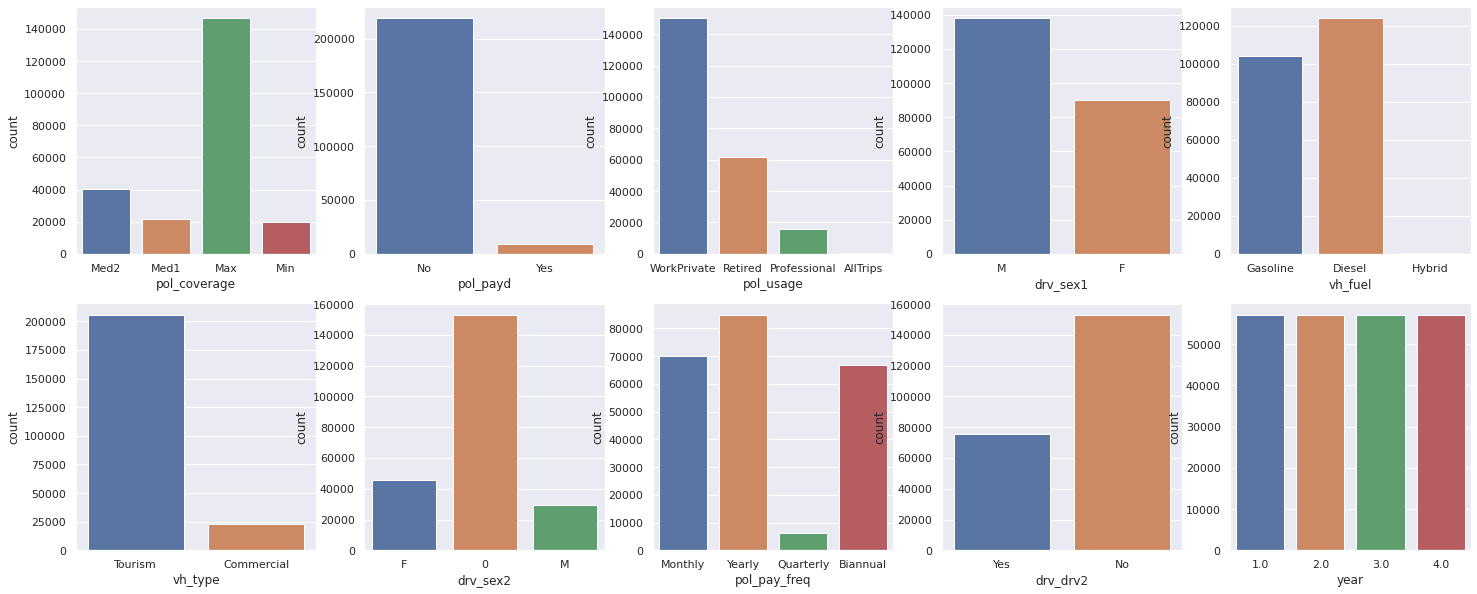

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2,figsize=(25, 10))
for i in range(len(cat_feats)):
  sns.countplot(x=df[cat_feats[i]], ax =ax[i//5, i % 5])

### Numerical Features

None of the features look normal-like, with the exception of `drv_age1, drv_age_lic1, drv_age2, drv_age_lic2` , which suggests a log-transform or power transform, in addition to normalization could be applied

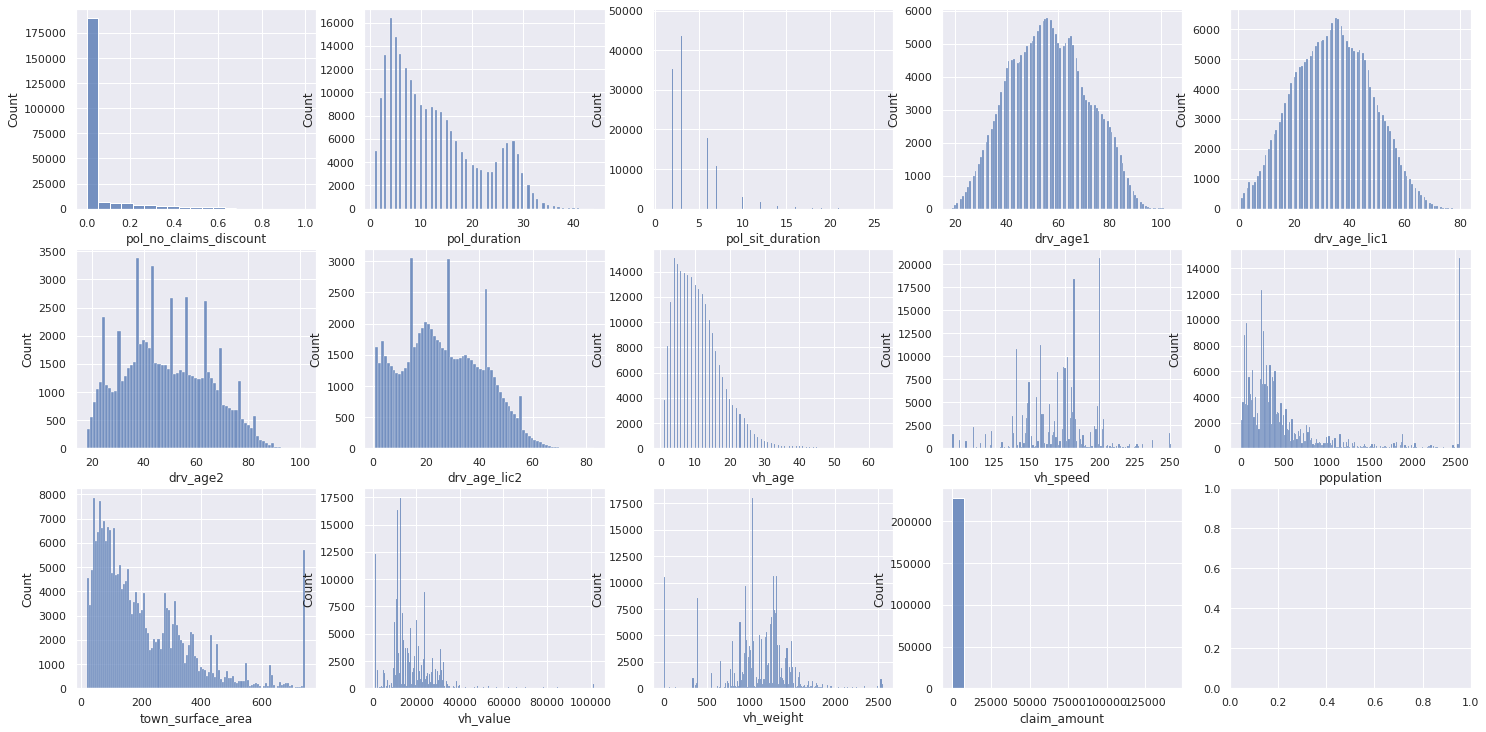

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=3,figsize=(25, 12.5))
for i in range(len(num_feats)):
  sns.histplot(x=df[num_feats[i]], ax =ax[i//5, i % 5])
sns.histplot(df['claim_amount'],ax=ax[2,3])

the distribution of `claim_amount | claim_amount > 0` looks more "normal like" after applying a log transform, suggesting that it may be Gamma-distributed or Log-normally distributed, which could be a consideration for linear models

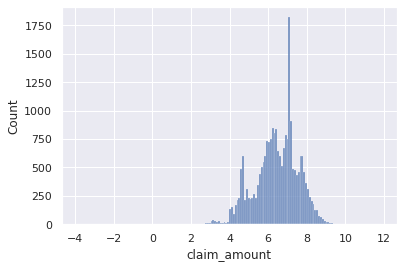

In [ ]:
sns.histplot(np.log(df2['claim_amount']))

## Bivariate

### Correlations

We can consider the correlations for
+ All the features $\mathbf{X}$
+ The distribution of features for `claim_amount > 0`  : $\mathbf{X}|y > 0$


In terms of both Spearman and Pearson correlation, the correlation between the covariates and the targets is low: $|Corr(X_{i}, Y)|< 0.11$. 

The Spearman correlation seems higher, which might suggest nonlinear dependence. There are clusters of covariates, which might be a problem for linear models. This may be less of a problem for Tree based models or other nonlinear models, but for tree-based models might suggest the same information (the correlated features) will be used more in the tree construction.



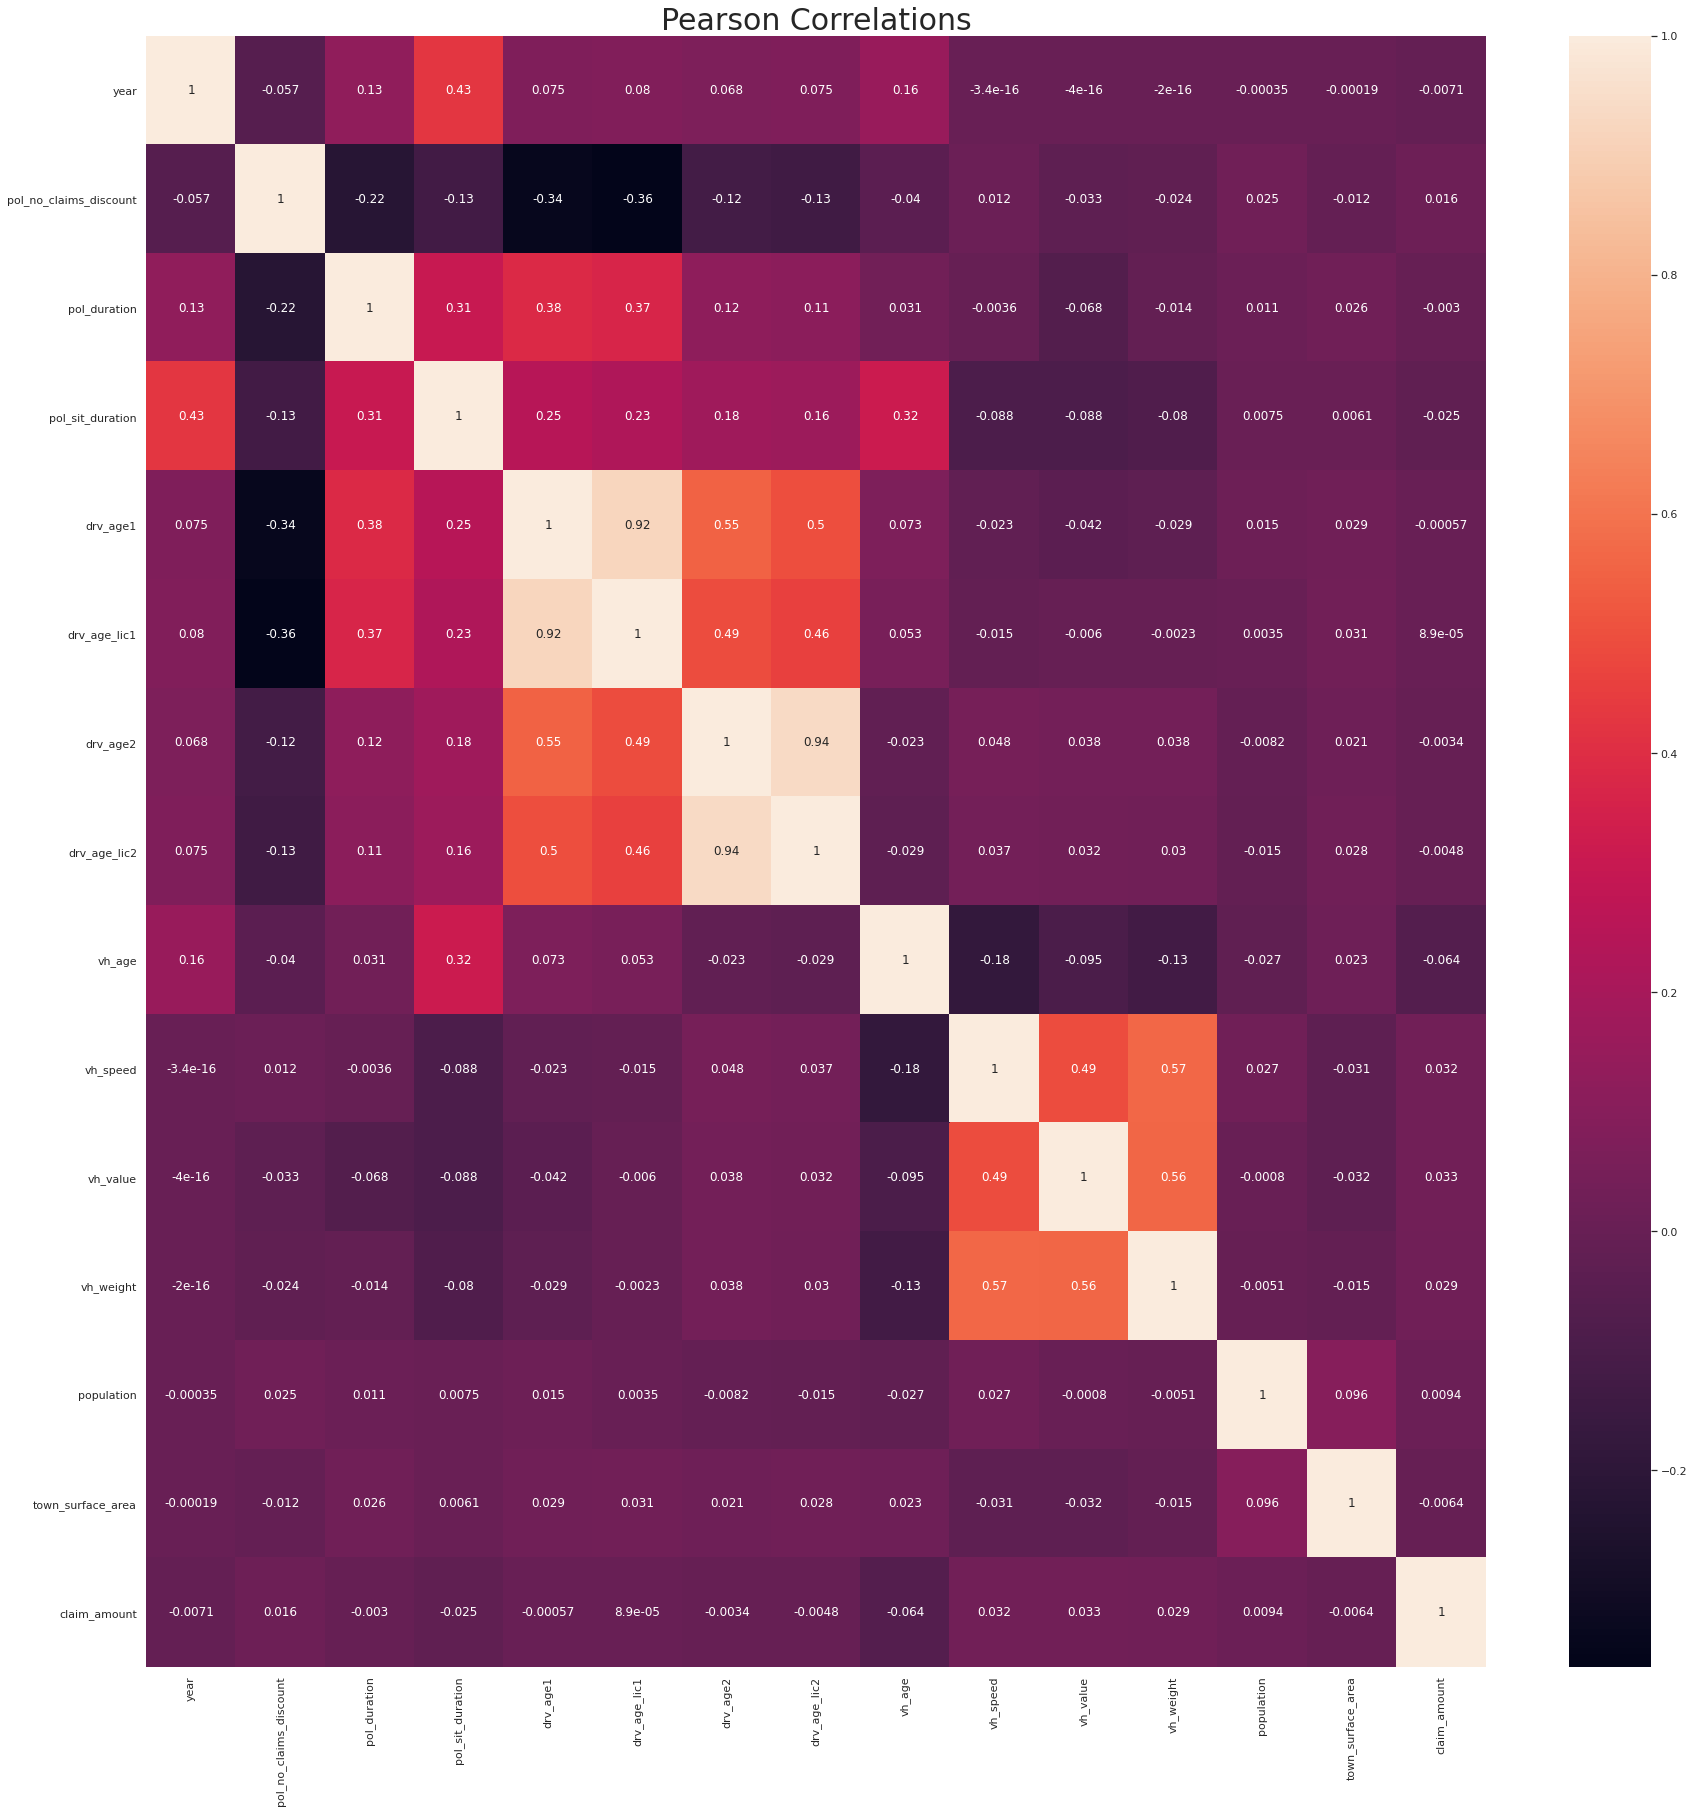

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df.corr(method='pearson'),annot=True,ax=ax)
ax.set_title("Pearson Correlations",fontsize=30);

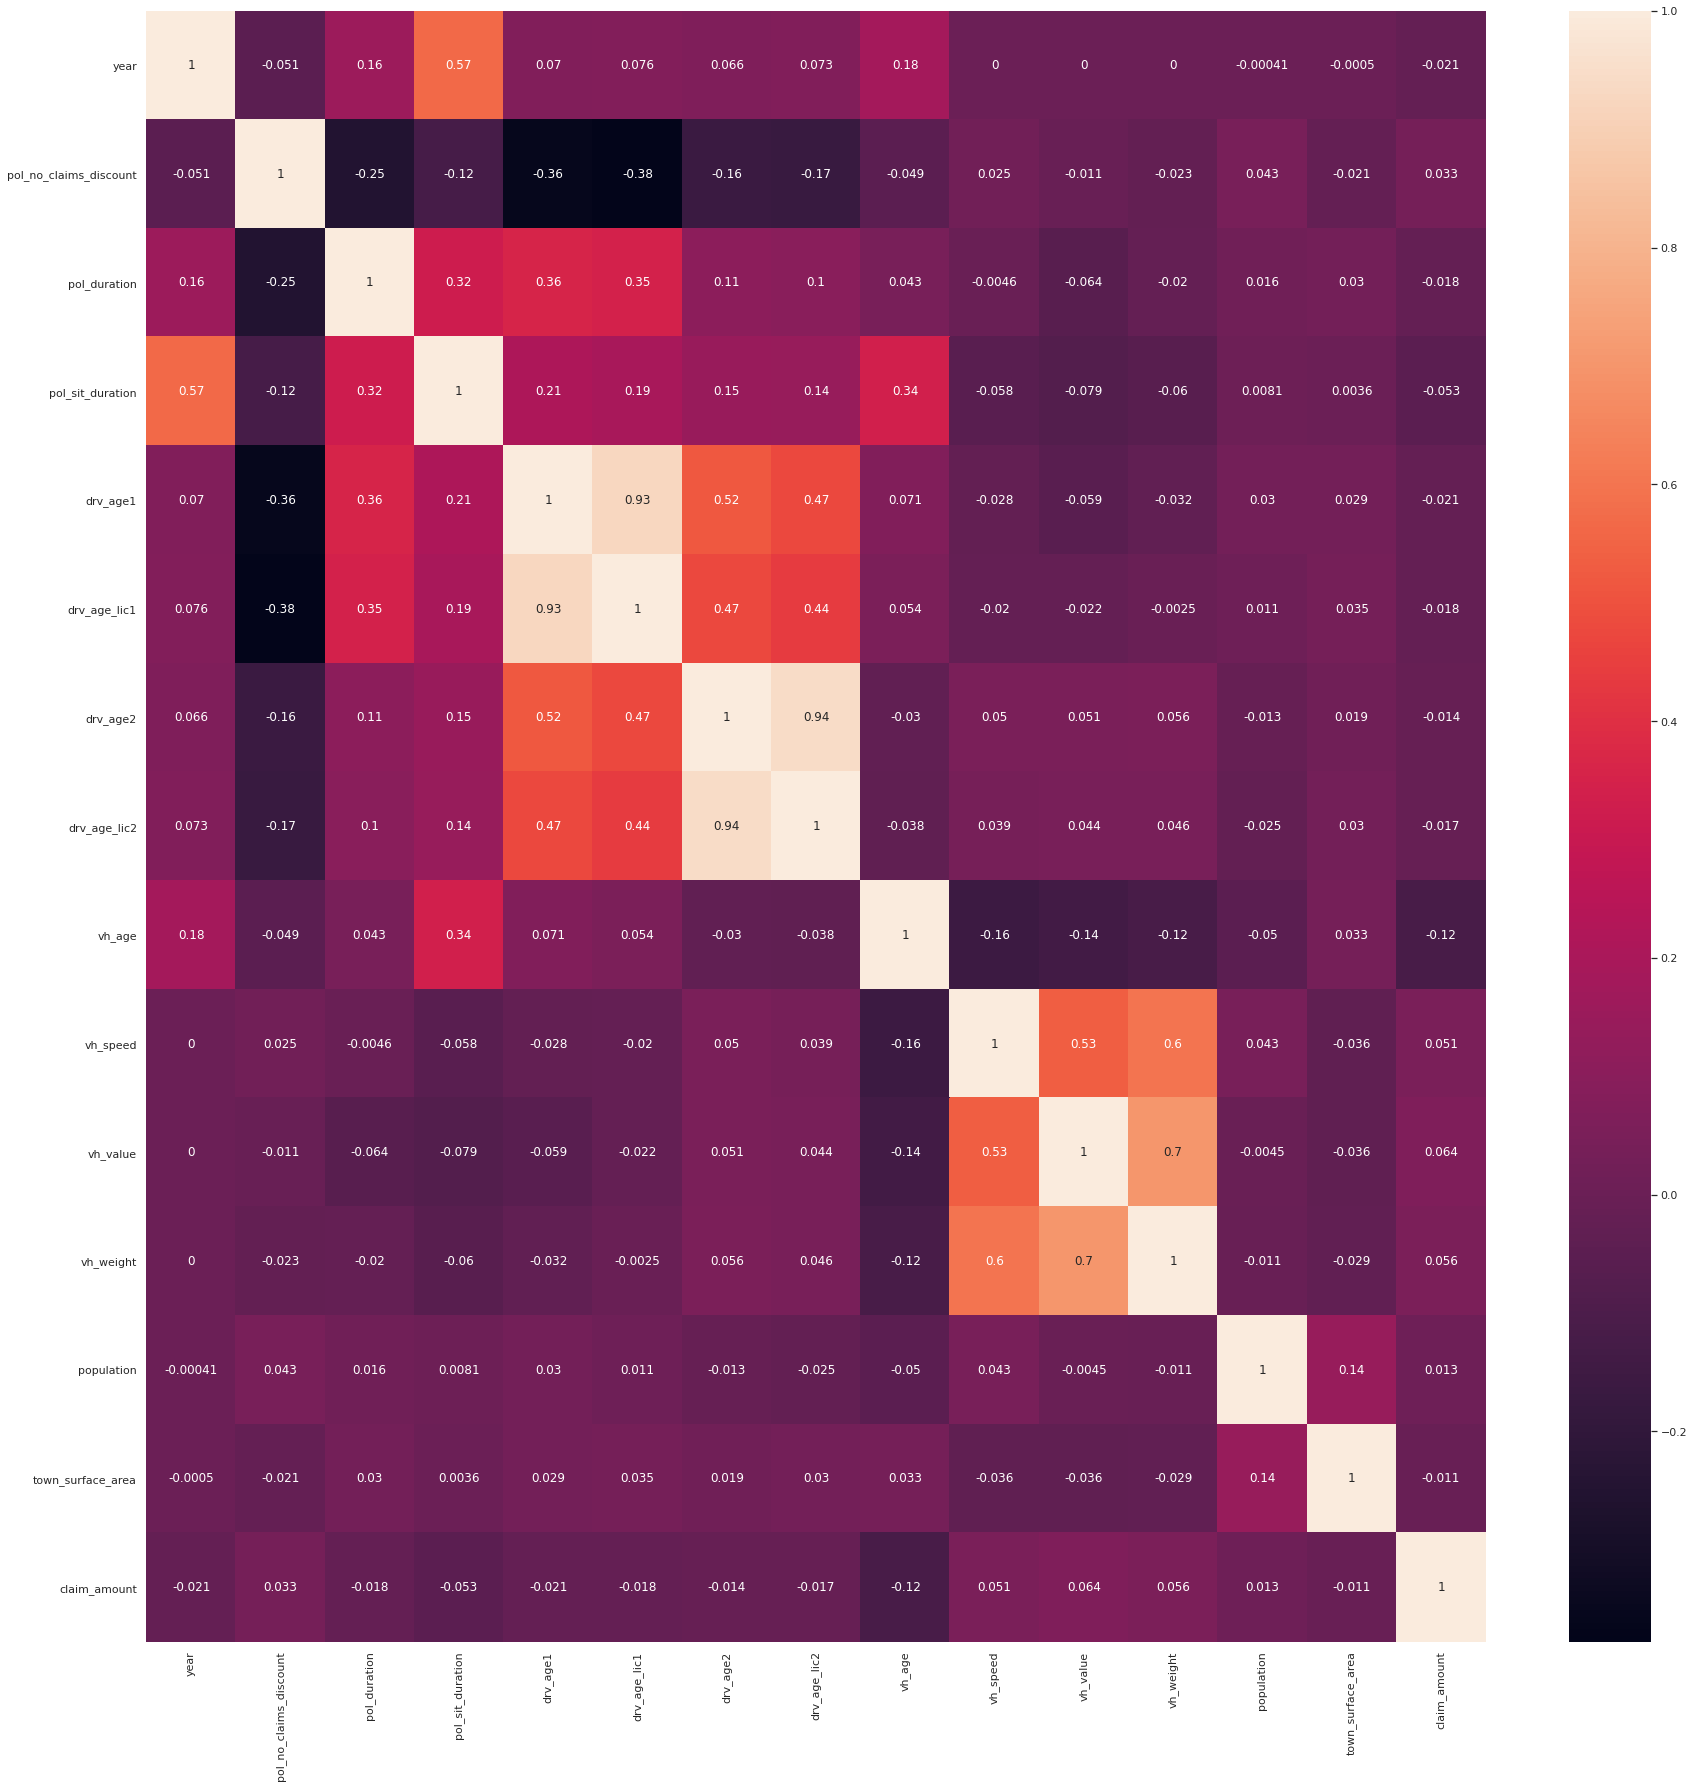

In [ ]:
#spearman, all features
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df.corr(method='spearman'),annot=True,ax=ax)
ax.set_title("Spearman Correlations",fontsize=30);

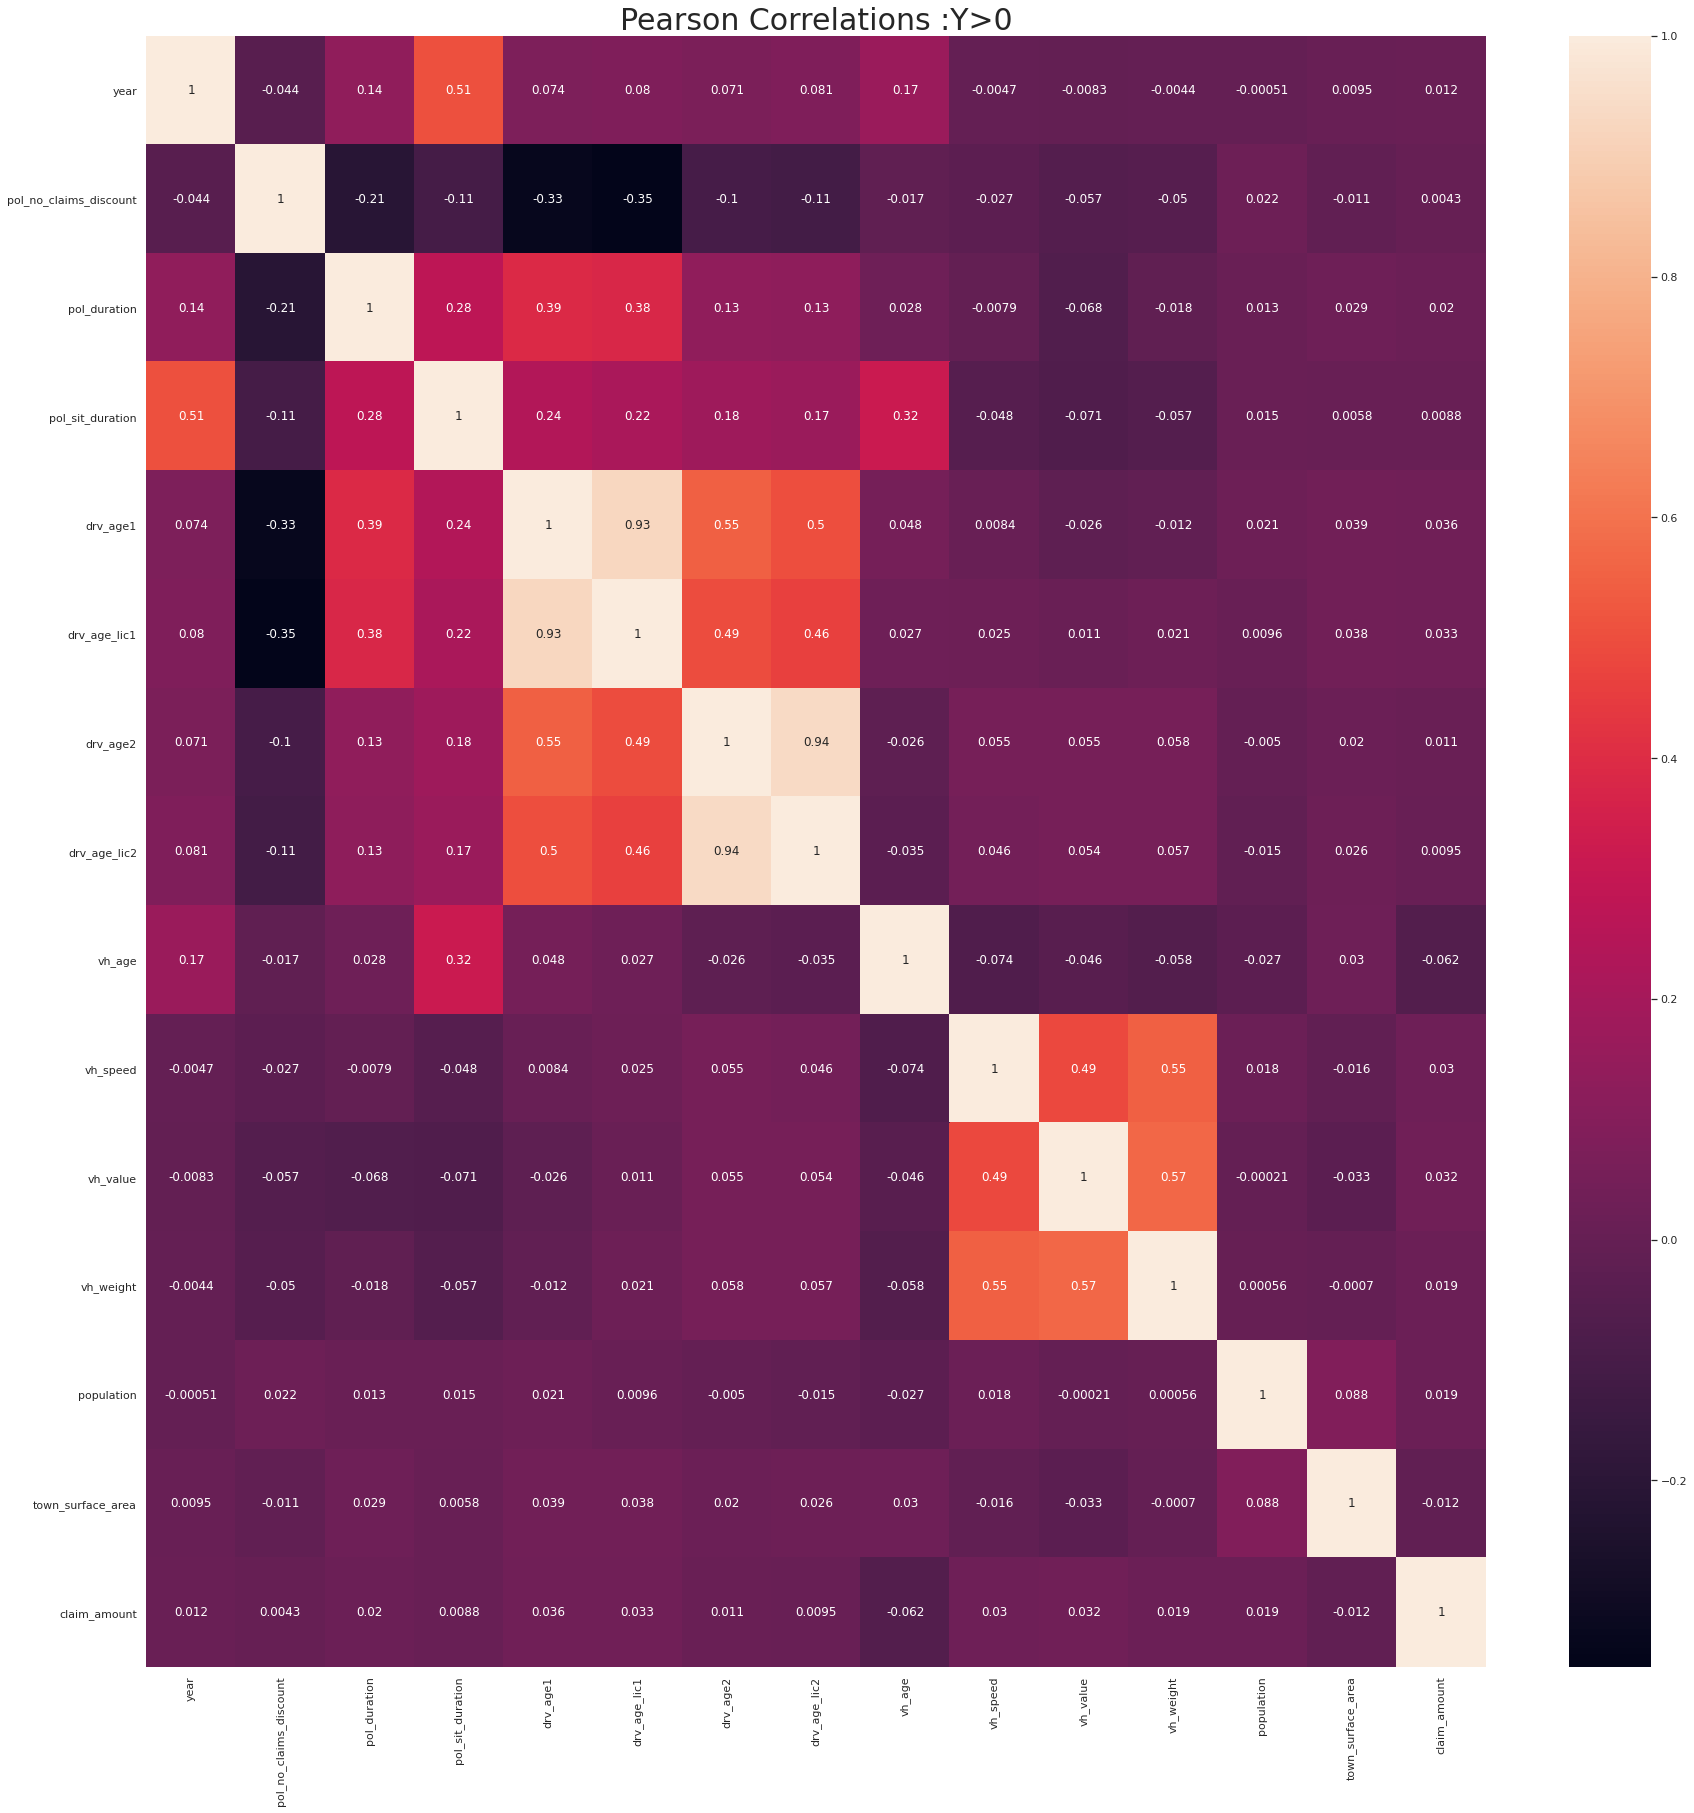

In [ ]:
#spearman, all features
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df2.corr(method='pearson'),annot=True,ax=ax)
ax.set_title("Pearson Correlations :Y>0",fontsize=30);

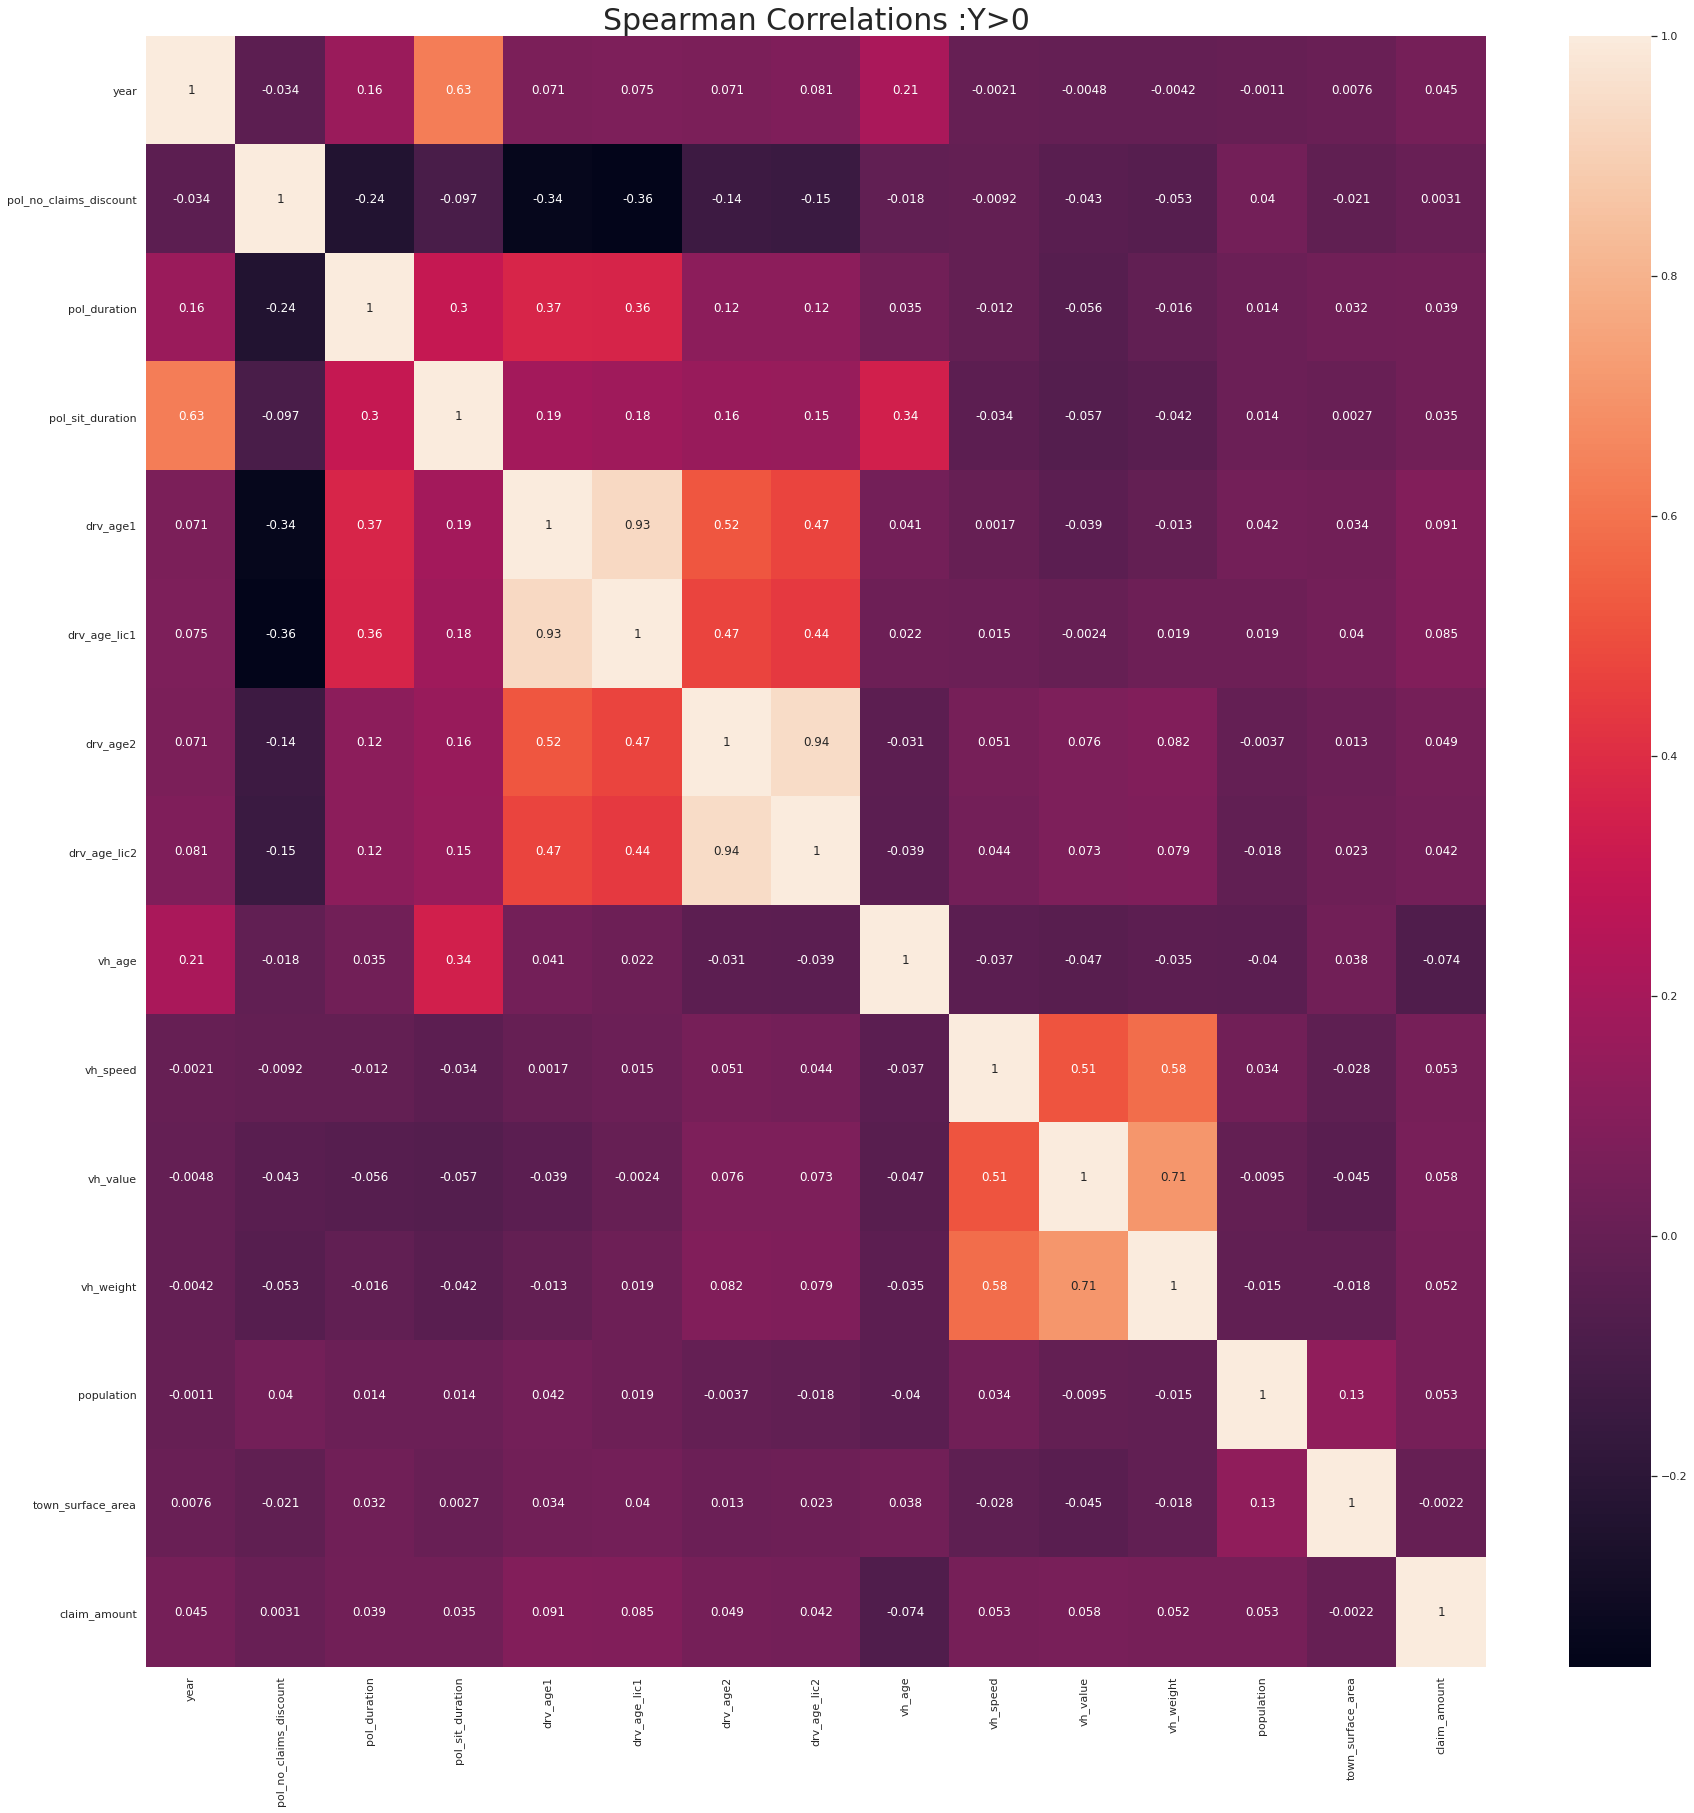

In [ ]:
#spearman, all features
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df2.corr(method='spearman'),annot=True,ax=ax)
ax.set_title("Spearman Correlations",fontsize=30);

### Pair Plots

Given the dataset consists of 24 features, it might be more feasible to just plot the bivariate relationships between the features and the target, `claim_amount` (or `np.log(claim_amount)` using scatter plots for the numerical features and a boxplot for the categorical

#### Numerical Features against Claim Amount

By eye, there do not appear to be strong linear relationships between the features and `claim_amount`. The plots for `vh_age, pol_no_claims_discount, pol_duration, pol_sit_duration` may suggest some heteroskedascity - clusters between claims which are very large versus smaller claims

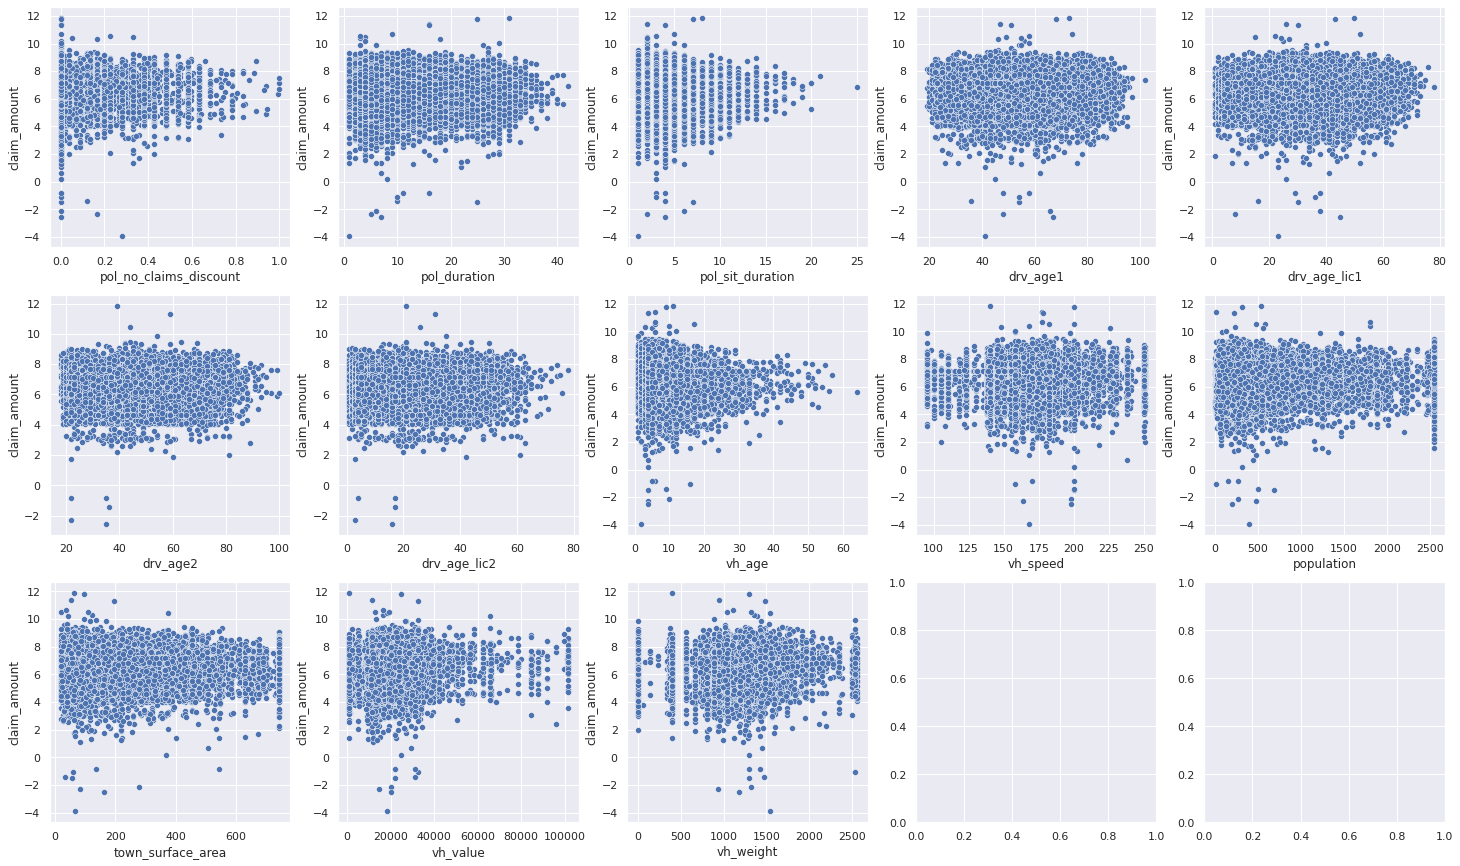

In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(25,15))
for i in range(len(num_feats)):
  sns.scatterplot(x=df2[num_feats[i]], y=np.log(df2['claim_amount']),ax=ax[i//5, i % 5])

#### Numerical Features against Claimed

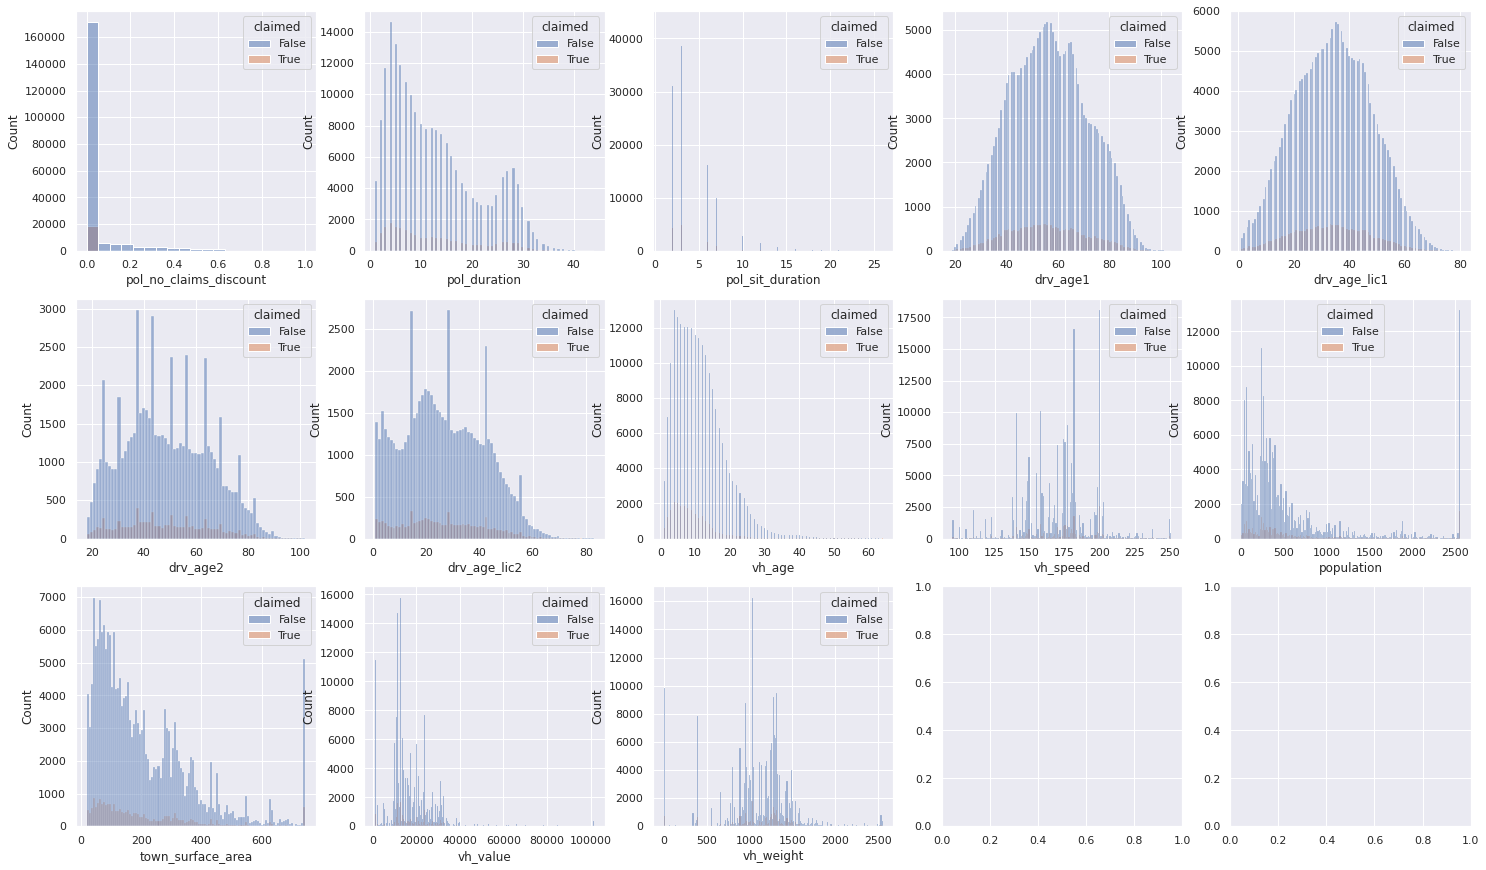

In [58]:
fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(25,15))
for i in range(len(num_feats)):
  sns.histplot(x=df[num_feats[i]], hue=df['claimed'], ax=ax[i//5, i % 5], common_norm=False)

#### Categorical Features against Claim Amount

By eye, there d onot appear to be very discernable differences between each categorical variable and `claim_amount`

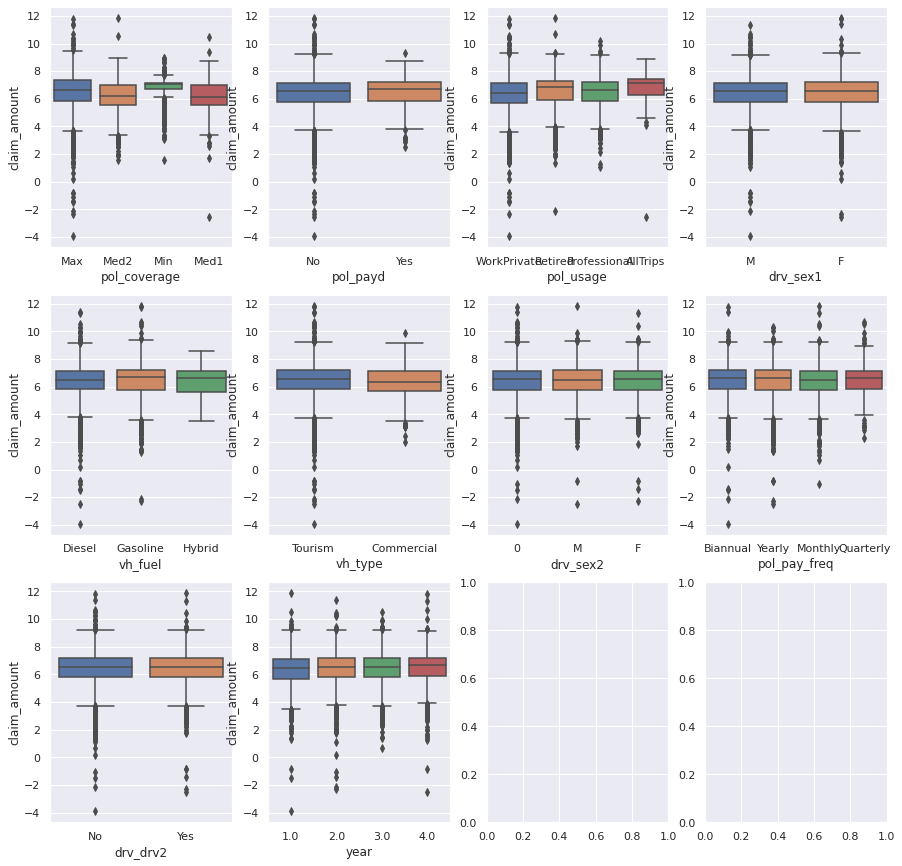

In [70]:
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(15,15))
for i in range(len(cat_feats)):
  sns.boxplot(x=df2[cat_feats[i]], y=np.log(df2['claim_amount']),ax=ax[i//4, i % 4])

#### Categorical Features against Claimed

By eye, the frequencies grouped by claimed appear to be quite similar, but we could greater clarity if normalised the columns, or looked at the coefficients from Logistic Regression

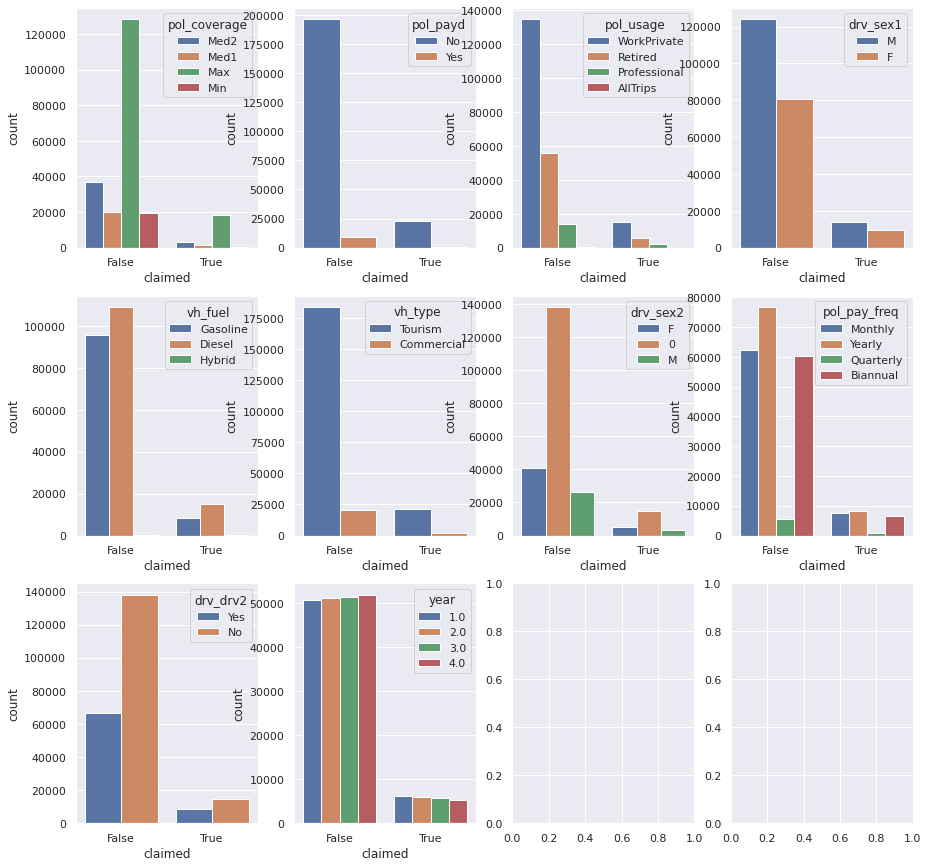

In [68]:
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(15,15))
for i in range(len(cat_feats)):
  sns.countplot(x=df['claimed'],hue=df[cat_feats[i]],ax=ax[i//4, i % 4])

## Metrics Benchmarks

Finally we can consider some benchmark metrics for our modelling step. We can consider the modelling part of this competition in terms of:
+ Classification - predict the likelihood a claim is made
+ Regression - predict the magnitude of a claim

**Regression**

**RMSE** gives us the square root of the average square distance of our predictions, penalising large deviations, which is import as we would want to minimise the error for an observation with a large `claim_amount`. We could also look at **MAE**, which would give us an average amount our predictions were incorrect.
+ RMSE: 725.1237978002649 on the whole dataset
+ RMSE: 2006.984773566635  only on insurance claims, claims > 0

**Classification**

Since most of the observations are *not* claims, classification may not be the most appropriate measure if we consider the task from a classification perspective. Some alternative metrics could be the F1-Score or ROC-AUC

+ Accuracy:  0.10206120517404564 (assume all are claims) 
+ Accuracy : 0.8979387948259544 (assume all are not claims)
+ F1-Score : 0.18521876043704374 (weighted measure of precision and recall, assume all are claims)
+ ROC-AUC : 0.5. Evaluates quality of predicted probabilities

**Pricing**
Since our final objective is to come up with a competitive pricing strategy, we evaluate the profit of our pricing rule if we were monpolistic:
$$ Monopolistic\_Profit = \sum_{i = 1}^{N} (\hat{Price}_{i} - Amount\_Claimed_{i}) $$
+ Monopolistic training profit : 0 (set all predictions to mean(y))

In [71]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
print("Root Mean Squared Error: ",mean_squared_error(df['claim_amount'], np.mean(df['claim_amount']) + np.zeros(df.shape[0]), squared=False))
print("Root Mean Squared Error: claims| claims > 0",mean_squared_error(df2['claim_amount'], np.mean(df2['claim_amount']) + np.zeros(df2.shape[0]), squared=False))
print("Accuracy (all claims): ",accuracy_score(df['claim_amount'] > 0,  1 + np.zeros(df.shape[0])))
print("Accuracy (none claims): ",accuracy_score(df['claim_amount'] > 0,  np.zeros(df.shape[0])))
print("F1-Score (all claims): ",f1_score(df['claim_amount'] > 0,  1 + np.zeros(df.shape[0])))

Root Mean Squared Error:  725.1237978002649
Root Mean Squared Error: claims| claims > 0 2006.984773566635
Accuracy (all claims):  0.10206120517404564
Accuracy (none claims):  0.8979387948259544
F1-Score (all claims):  0.18521876043704374


## Next Steps

**Further EDA**
+ We could apply dimensionality reduction to see if there are any patterns in lower dimensions, using PCA, TSNE etc.
+ We could apply clustering to find latent groups of policies, and whether some are associated with a higher probability/higher claim_amount

**Modelling**
+ A first step could be to explore GLMs to predict the insurance claim size (Linear Regression, Gamma/Tweedie Regression etc.) and also the probability of a claim (Logistic Regression)
+ Using nonlinear learners : LightGBM, XGBoost, Deep Neural Networks